In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics

data

In [13]:
# 데이터 불러오기
path = 'C:/Users/user/HCS_ML/data/rail_weather_dataset_utf8.csv'
data_csv = pd.read_csv(path)
data=data_csv.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96128 entries, 0 to 96127
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Time                        96128 non-null  object 
 1   Temperature                 96128 non-null  float64
 2   Accumulated_precipitation   96128 non-null  float64
 3   Wind_direction              96128 non-null  float64
 4   Wind_speed                  96128 non-null  float64
 5   Local_atmospheric_pressure  96128 non-null  float64
 6   Sea_level_pressure          96128 non-null  float64
 7   Humidity                    96128 non-null  float64
 8   Solar_radiation_MJ_m2       96128 non-null  float64
 9   Solar_radiation_sec         96128 non-null  int64  
 10  rail_temp                   96128 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 8.1+ MB


In [14]:
# Time의 파일 형식이 object라서 XGBoost에 학습시킬 수 없었음
# Time에서 년,월, 일, 시간, 분으로 나누어 구성
# 데이터의 차원이 크게 늘었지만, 각 특성이 어떤 영향을 미치는지를 추가적으로 확인할 수 있을 것으로 기대

# Time 데이터를 판다스로 읽어옴
def preprocess_season_data(data):
    # Read Time data into Pandas
    data['Time'] = pd.to_datetime(data['Time'])

    # Save each data as a new feature
    data.loc[:, 'year'] = data['Time'].dt.year
    data.loc[:, 'month'] = data['Time'].dt.month
    data.loc[:, 'day'] = data['Time'].dt.day
    data.loc[:, 'hour'] = data['Time'].dt.hour
    data.loc[:, 'minute'] = data['Time'].dt.minute

    # Delete the Time attribute
    data.drop('Time', axis=1, inplace=True)

    return data

data = preprocess_season_data(data)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96128 entries, 0 to 96127
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Temperature                 96128 non-null  float64
 1   Accumulated_precipitation   96128 non-null  float64
 2   Wind_direction              96128 non-null  float64
 3   Wind_speed                  96128 non-null  float64
 4   Local_atmospheric_pressure  96128 non-null  float64
 5   Sea_level_pressure          96128 non-null  float64
 6   Humidity                    96128 non-null  float64
 7   Solar_radiation_MJ_m2       96128 non-null  float64
 8   Solar_radiation_sec         96128 non-null  int64  
 9   rail_temp                   96128 non-null  float64
 10  year                        96128 non-null  int64  
 11  month                       96128 non-null  int64  
 12  day                         96128 non-null  int64  
 13  hour                        961

In [15]:
# 문제와 답으로 분리 
def train_test(data):
    X = data.drop('rail_temp', axis=1)
    Y = data['rail_temp']
    import math
    X_train, X_test = X.iloc[:math.floor(len(X)*0.7)], X.iloc[math.floor(len(X)*0.7):]
    Y_train, Y_test = Y.iloc[:math.floor(len(Y)*0.7)], Y.iloc[math.floor(len(Y)*0.7):]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = train_test(data)
X_train.head()

,Temperature,Accumulated_precipitation,Wind_direction,Wind_speed,Local_atmospheric_pressure,Sea_level_pressure,Humidity,Solar_radiation_MJ_m2,Solar_radiation_sec,year,month,day,hour,minute
0,26.8,0.0,324.8,0.3,1002.6,1010.4,74.8,27.28,39960,2018,7,20,0,0
1,26.7,0.0,346.9,0.4,1002.6,1010.4,75.4,0.00,0,2018,7,20,0,10
2,26.5,0.0,0.0,0.1,1002.5,1010.3,77.0,0.00,0,2018,7,20,0,20
3,26.5,0.0,75.3,0.4,1002.4,1010.2,77.0,0.00,0,2018,7,20,0,30
4,26.5,0.0,42.1,0.2,1002.4,1010.2,73.7,0.00,0,2018,7,20,0,40


model_default

In [16]:
# XGBoost로 학습

Rail_reg = xgb.XGBRegressor()
Rail_reg.fit(X_train, Y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

test
score
0.9876443007440212
rmse
1.5539351055162254
r2
0.9883712032269898

train
score
0.9955494036997222
rmse
0.9556779829188029
r2
0.9955264409515868


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

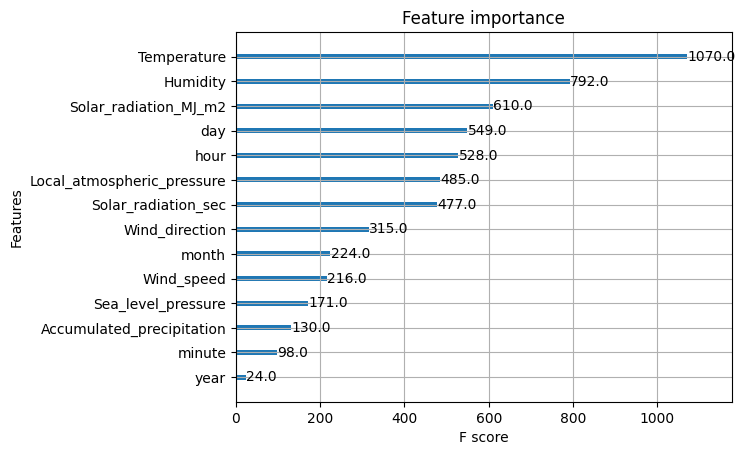

In [17]:
#성능 검사 및 변수 중요도 파악
def perpomance_data(Rail_reg, X_train, X_test, Y_train, Y_test):
    pre_test = Rail_reg.predict(X_test)                                 ; pre_train = Rail_reg.predict(X_train)
    score_test = Rail_reg.score(X_test, Y_test)                         ; score_train = Rail_reg.score(X_train, Y_train)
    rmse_test = np.sqrt(metrics.mean_squared_error(pre_test, Y_test))   ; rmse_train = np.sqrt(metrics.mean_squared_error(pre_train, Y_train))
    r2_test=metrics.r2_score(pre_test,Y_test)                           ; r2_train=metrics.r2_score(pre_train,Y_train)
    print("test") ;print("score") ;print(score_test) ;print("rmse") ; print(rmse_test) ; print("r2") ;print(r2_test)
    print()
    print("train") ;print("score") ;print(score_train) ; print("rmse") ;print(rmse_train) ;print("r2") ; print(r2_train)


    return xgb.plot_importance(Rail_reg)

perpomance_data(Rail_reg, X_train, X_test, Y_train, Y_test)


model__default_save

In [18]:
import joblib
import pickle

# train your machine learning model
model = Rail_reg # your trained model

# export the model as a pickle file
filename = 'Weather_Rail_XGBoost_1.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [19]:
loaded_model = pickle.load(open(filename, 'rb'))


data_spearate

In [20]:
# Load the data into a pandas DataFrame

df = pd.read_csv(path).copy()

# Convert the 'Time' column to a datetime data type
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M')

# Create a new column for the season based on the dates
df['Season'] = pd.cut(df['Time'].dt.dayofyear + 11, [0,80,172,264,355,366], labels=['Winter', 'Spring', 'Summer', 'Fall', 'Winter'], ordered=False)

# Split the data by season
winter_data = df[df['Season'] == 'Winter'].copy()
spring_data = df[df['Season'] == 'Spring'].copy()
summer_data = df[df['Season'] == 'Summer'].copy()
fall_data = df[df['Season'] == 'Fall'].copy()


In [21]:
def preprocess_season_data(data):
    # Read Time data into Pandas
    data['Time'] = pd.to_datetime(data['Time'])

    # Save each data as a new feature
    data.loc[:, 'year'] = data['Time'].dt.year
    data.loc[:, 'month'] = data['Time'].dt.month
    data.loc[:, 'day'] = data['Time'].dt.day
    data.loc[:, 'hour'] = data['Time'].dt.hour
    data.loc[:, 'minute'] = data['Time'].dt.minute

    # Delete the Time attribute
    data.drop('Time', axis=1, inplace=True)

    return data


winter_data = preprocess_season_data(winter_data); winter_data.drop('Season', axis=1, inplace=True)
spring_data = preprocess_season_data(spring_data); spring_data.drop('Season', axis=1, inplace=True)
summer_data = preprocess_season_data(summer_data); summer_data.drop('Season', axis=1, inplace=True)
fall_data = preprocess_season_data(fall_data); fall_data.drop('Season', axis=1, inplace=True)


In [22]:
X_train_winter, X_test_winter, Y_train_winter, Y_test_winter = train_test(winter_data)
X_train_spring, X_test_spring, Y_train_spring, Y_test_spring = train_test(spring_data)
X_train_summer, X_test_summer, Y_train_summer, Y_test_summer = train_test(summer_data)
X_train_fall, X_test_fall, Y_train_fall, Y_test_fall = train_test(fall_data)

X_train_fall.head()


,Temperature,Accumulated_precipitation,Wind_direction,Wind_speed,Local_atmospheric_pressure,Sea_level_pressure,Humidity,Solar_radiation_MJ_m2,Solar_radiation_sec,year,month,day,hour,minute
7307,19.3,0.0,115.8,2.7,1014.2,1022.3,61.3,21.6,39720,2018,9,11,0,0
7308,19.1,0.0,135.9,2.6,1014.2,1022.3,62.1,0.0,0,2018,9,11,0,10
7309,19.1,0.0,107.3,2.8,1014.1,1022.2,62.3,0.0,0,2018,9,11,0,20
7310,18.9,0.0,126.7,3.1,1014.1,1022.2,63.4,0.0,0,2018,9,11,0,30
7311,18.8,0.0,111.1,3.4,1014.0,1022.1,63.9,0.0,0,2018,9,11,0,40


model_season

In [23]:
Rail_reg_winter = xgb.XGBRegressor()
Rail_reg_winter.fit(X_train_winter, Y_train_winter, verbose=False)

Rail_reg_spring = xgb.XGBRegressor()
Rail_reg_spring.fit(X_train_spring, Y_train_spring, verbose=False)

Rail_reg_summer = xgb.XGBRegressor()
Rail_reg_summer.fit(X_train_summer, Y_train_summer, verbose=False)

Rail_reg_fall = xgb.XGBRegressor()
Rail_reg_fall.fit(X_train_fall, Y_train_fall, verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

test
score
0.961198856536807
rmse
1.5699686639158321
r2
0.9477114679664703

train
score
0.9938074587646224
rmse
0.520606392368593
r2
0.9937582148018005


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

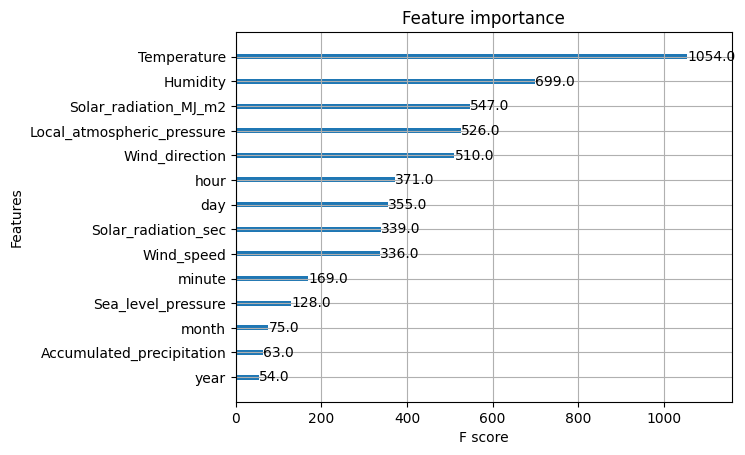

In [24]:
perpomance_data(Rail_reg_winter, X_train_winter, X_test_winter, Y_train_winter, Y_test_winter)

test
score
0.9764414351555624
rmse
1.5426597376942797
r2
0.9796989612387101

train
score
0.9973990041113088
rmse
0.5940023481537703
r2
0.9973886620824779


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

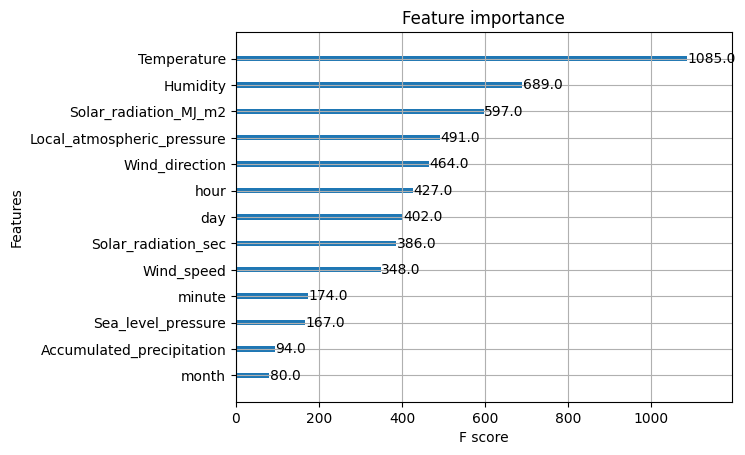

In [25]:
perpomance_data(Rail_reg_spring, X_train_spring, X_test_spring, Y_train_spring, Y_test_spring)

test
score
0.9737304936953896
rmse
1.3053915717570275
r2
0.976731077393842

train
score
0.9942036002520676
rmse
0.7480617245595187
r2
0.9941556414356295


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

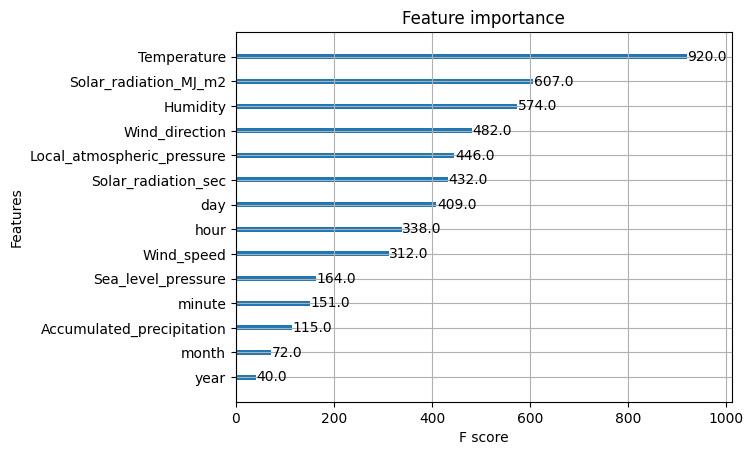

In [26]:
perpomance_data(Rail_reg_summer, X_train_summer, X_test_summer, Y_train_summer, Y_test_summer)

test
score
0.97070990865864
rmse
1.6492028138546182
r2
0.9638124469926412

train
score
0.9971823047185019
rmse
0.5620258327778926
r2
0.9971734107320652


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

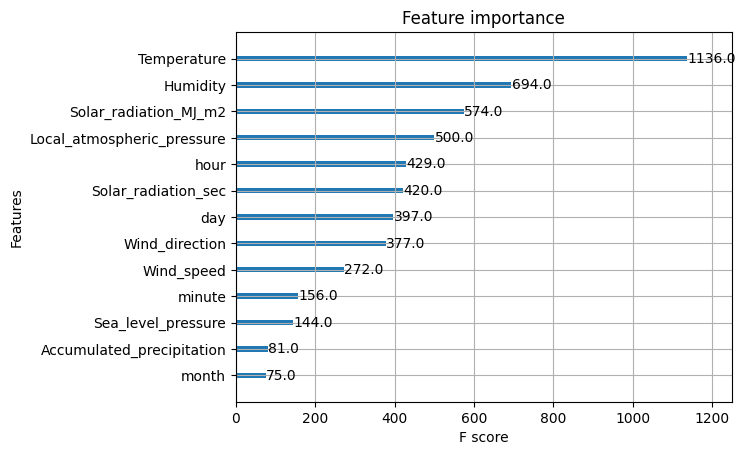

In [27]:
perpomance_data(Rail_reg_fall, X_train_fall, X_test_fall, Y_train_fall, Y_test_fall)

model_season_save

In [28]:
# train your machine learning model
model = Rail_reg_winter # your trained model

# export the model as a pickle file
filename = 'Weather_Rail_XGBoost_winter.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [29]:
# train your machine learning model
model = Rail_reg_spring # your trained model

# export the model as a pickle file
filename = 'Weather_Rail_XGBoost_spring.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [30]:
# train your machine learning model
model = Rail_reg_summer # your trained model

# export the model as a pickle file
filename = 'Weather_Rail_XGBoost_summer.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [31]:
# train your machine learning model
model = Rail_reg_fall # your trained model

# export the model as a pickle file
filename = 'Weather_Rail_XGBoost_fall.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

test
score
0.4578399617723118
rmse
10.293497546151695
r2
-0.8194122256970995

train
score
-0.004459375364413987
rmse
14.35716421623439
r2
-4.567983810031425


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

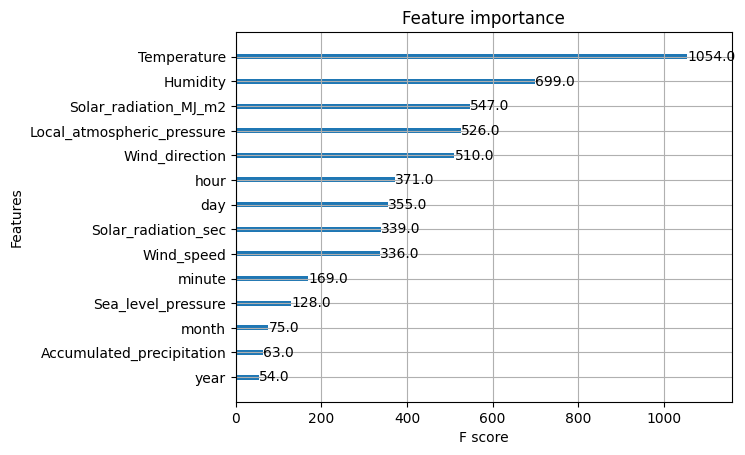

In [32]:
perpomance_data(Rail_reg_winter, X_train, X_test, Y_train, Y_test)

test
score
0.9481652614309344
rmse
3.18280234925532
r2
0.9484162271576668

train
score
0.9489880053141058
rmse
3.235479350212583
r2
0.946454887205884


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

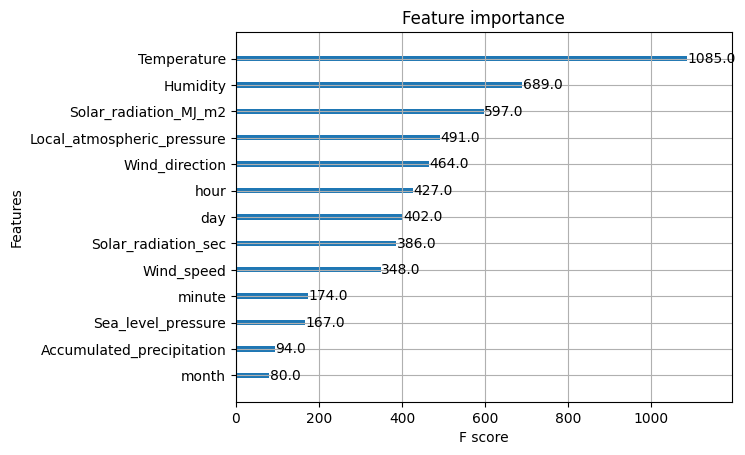

In [33]:
perpomance_data(Rail_reg_spring, X_train, X_test, Y_train, Y_test)

test
score
0.3484826683743012
rmse
11.283977209731892
r2
-0.9103729994661791

train
score
0.6515922391260003
rmse
8.455638153685344
r2
0.21651684505859758


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

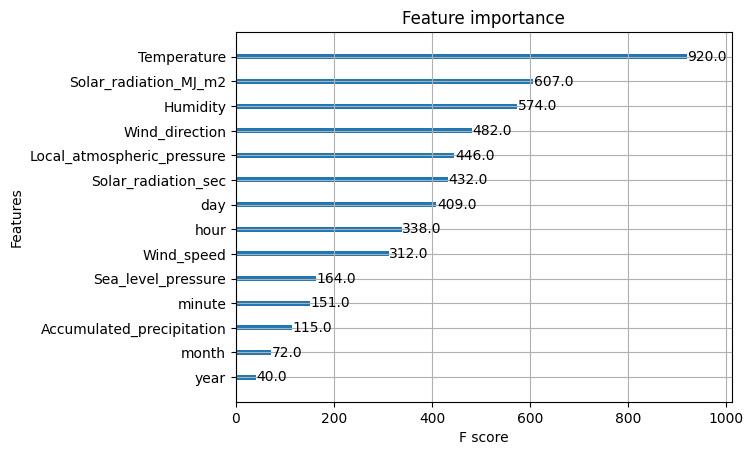

In [34]:
perpomance_data(Rail_reg_summer, X_train, X_test, Y_train, Y_test)

test
score
0.9559881745665405
rmse
2.932809838788934
r2
0.9561076442216612

train
score
0.9554005176844483
rmse
3.0252926227143604
r2
0.9472849456158334


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

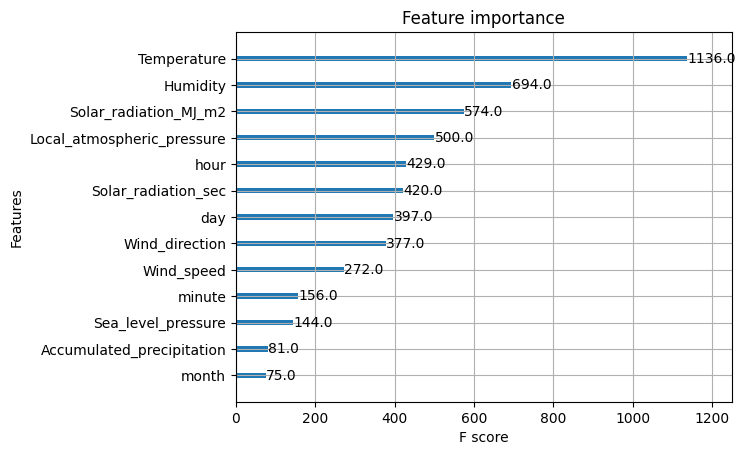

In [35]:
perpomance_data(Rail_reg_fall, X_train, X_test, Y_train, Y_test)

ensemble_voting

In [73]:
import pickle

# Load the saved models
with open('Weather_Rail_XGBoost_winter.pkl', 'rb') as f:
    model_winter = pickle.load(f)

with open('Weather_Rail_XGBoost_spring.pkl', 'rb') as f:
    model_spring = pickle.load(f)

with open('Weather_Rail_XGBoost_summer.pkl', 'rb') as f:
    model_summer = pickle.load(f)

with open('Weather_Rail_XGBoost_fall.pkl', 'rb') as f:
    model_fall = pickle.load(f)

In [74]:
from sklearn.metrics import r2_score

def model_ensemble_voting_predict_score(X,Y):
    pred_spring = model_spring.predict(X)
    pred_summer = model_summer.predict(X)
    pred_fall = model_fall.predict(X)
    pred_winter = model_winter.predict(X)

    predict= np.mean([pred_spring, pred_summer, pred_fall, pred_winter], axis=0)
    score=r2_score(Y, predict)
    return predict, score

In [75]:
with open('model_ensemble_voting.pkl', 'wb') as file:
    pickle.dump(model_ensemble_voting_predict_score, file)

In [76]:
with open('model_ensemble_voting.pkl', 'rb') as f:
    model_ensemble_voting = pickle.load(f)

In [77]:
#성능 검사 및 변수 중요도 파악
def performance_data_ensemble_voting(X_train, X_test, Y_train, Y_test):
    pre_test, score_test = model_ensemble_voting_predict_score(X_test, Y_test)
    pre_train, score_train = model_ensemble_voting_predict_score(X_train, Y_train)

    rmse_test = np.sqrt(metrics.mean_squared_error(pre_test, Y_test))   ; rmse_train = np.sqrt(metrics.mean_squared_error(pre_train, Y_train))
    r2_test=metrics.r2_score(pre_test,Y_test)                           ; r2_train=metrics.r2_score(pre_train,Y_train)
    print("test") ;print("score") ;print(score_test) ;print("rmse") ; print(rmse_test) ; print("r2") ;print(r2_test)
    print()
    print("train") ;print("score") ;print(score_train) ; print("rmse") ;print(rmse_train) ;print("r2") ; print(r2_train)


    return xgb.plot_importance(Rail_reg)

test
score
0.9128608770343724
rmse
4.126727632062618
r2
0.842586795219407

train
score
0.8872141013080102
rmse
4.810939347399728
r2
0.7724203035815208


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

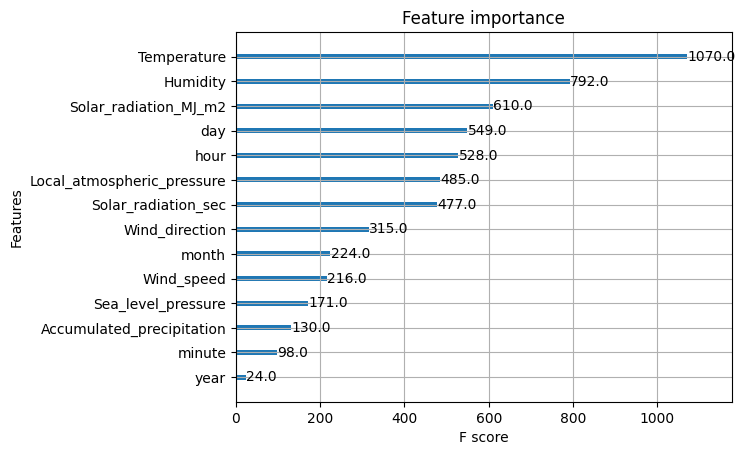

In [78]:
performance_data_ensemble_voting(X_train, X_test, Y_train, Y_test)

ensemble_bagging

In [99]:
from sklearn.ensemble import BaggingRegressor

# Load the saved models
with open('Weather_Rail_XGBoost_winter.pkl', 'rb') as f:
    model_winter = pickle.load(f)

with open('Weather_Rail_XGBoost_spring.pkl', 'rb') as f:
    model_spring = pickle.load(f)

with open('Weather_Rail_XGBoost_summer.pkl', 'rb') as f:
    model_summer = pickle.load(f)

with open('Weather_Rail_XGBoost_fall.pkl', 'rb') as f:
    model_fall = pickle.load(f)



In [100]:
models = ['Weather_Rail_XGBoost_spring.pkl', 'Weather_Rail_XGBoost_summer.pkl', 'Weather_Rail_XGBoost_fall.pkl', 'Weather_Rail_XGBoost_winter.pkl']
estimators = []

for model in models:
    with open(model, 'rb') as f:
        estimator = pickle.load(f)
        estimators.append(estimator)

bagging = BaggingRegressor(n_estimators=4, random_state=42)
bagging.estimators_ = estimators
bagging.fit(X_train, Y_train)

BaggingRegressor(n_estimators=4, random_state=42)

test
score
0.9876443007440212
rmse
1.5539351055162254
r2
0.9883712032269898

train
score
0.9955494036997222
rmse
0.9556779829188029
r2
0.9955264409515868


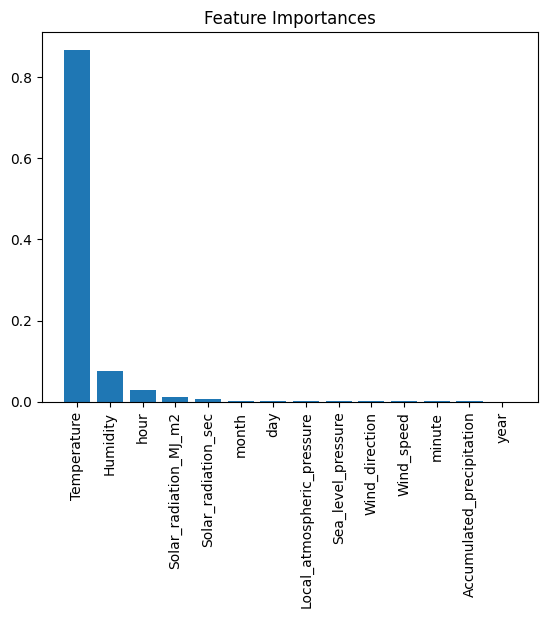

In [101]:
#성능 검사 및 변수 중요도 파악
def performance_data_ensemble_bagging(Rail_reg, X_train, X_test, Y_train, Y_test):
    pre_test = Rail_reg.predict(X_test)                                 ; pre_train = Rail_reg.predict(X_train)
    score_test = Rail_reg.score(X_test, Y_test)                         ; score_train = Rail_reg.score(X_train, Y_train)
    rmse_test = np.sqrt(metrics.mean_squared_error(pre_test, Y_test))   ; rmse_train = np.sqrt(metrics.mean_squared_error(pre_train, Y_train))
    r2_test=metrics.r2_score(pre_test,Y_test)                           ; r2_train=metrics.r2_score(pre_train,Y_train)
    print("test") ;print("score") ;print(score_test) ;print("rmse") ; print(rmse_test) ; print("r2") ;print(r2_test)
    print()
    print("train") ;print("score") ;print(score_train) ; print("rmse") ;print(rmse_train) ;print("r2") ; print(r2_train)

    feature_importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)

    # sort feature importances in descending order
    sorted_idx = np.argsort(feature_importances)[::-1]

    # plot feature importances
    plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx])
    plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
    plt.title("Feature Importances")


    return 

performance_data_ensemble_bagging(Rail_reg, X_train, X_test, Y_train, Y_test)


ensemble_stacking

In [106]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
import joblib

# Load the saved models
with open('Weather_Rail_XGBoost_winter.pkl', 'rb') as f:
    model_winter = pickle.load(f)

with open('Weather_Rail_XGBoost_spring.pkl', 'rb') as f:
    model_spring = pickle.load(f)

with open('Weather_Rail_XGBoost_summer.pkl', 'rb') as f:
    model_summer = pickle.load(f)

with open('Weather_Rail_XGBoost_fall.pkl', 'rb') as f:
    model_fall = pickle.load(f)


In [107]:
# Create a list of the models for stacking
estimators = [('spring', model_spring), 
              ('summer', model_summer), 
              ('fall', model_fall), 
              ('winter', model_winter)]

In [108]:
# Initialize the final estimator
final_estimator = LinearRegression()

# Create the stacking model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)

# Fit the model to the training data
stacking_model.fit(X_train, Y_train)

StackingRegressor(estimators=[('spring',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                  final_estimator=LinearRegression())

In [113]:
#성능 검사 및 변수 중요도 파악
def performance_data_ensemble_stacking(Rail_reg, X_train, X_test, Y_train, Y_test):
    pre_test = Rail_reg.predict(X_test)                                 ; pre_train = Rail_reg.predict(X_train)
    score_test = Rail_reg.score(X_test, Y_test)                         ; score_train = Rail_reg.score(X_train, Y_train)
    rmse_test = np.sqrt(metrics.mean_squared_error(pre_test, Y_test))   ; rmse_train = np.sqrt(metrics.mean_squared_error(pre_train, Y_train))
    r2_test=metrics.r2_score(pre_test,Y_test)                           ; r2_train=metrics.r2_score(pre_train,Y_train)
    print("test") ;print("score") ;print(score_test) ;print("rmse") ; print(rmse_test) ; print("r2") ;print(r2_test)
    print()
    print("train") ;print("score") ;print(score_train) ; print("rmse") ;print(rmse_train) ;print("r2") ; print(r2_train)
    '''
    base_model_winter_importances = model_winter.coef_
    base_model_spring_importances = model_spring.coef_
    base_model_summer_importances = model_summer.coef_
    base_model_fall_importances = model_fall.coef_
    
    overall_importances = (base_model_winter_importances + base_model_spring_importances + base_model_summer_importances + base_model_fall_importances) / 4

    # Create a bar chart
    plt.bar(range(len(overall_importances)), overall_importances)

    # Add labels and title
    plt.xticks(range(len(overall_importances)), X_test.columns, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Overall Feature Importance')

    # Show the plot
    plt.show()
    '''
    return 


performance_data_ensemble_stacking(stacking_model, X_train, X_test, Y_train, Y_test)


test
score
0.9874605745777003
rmse
1.5654457869014116
r2
0.9883315789134148

train
score
0.995466070100404
rmse
0.9645836140436546
r2
0.9954941495200963
